In [1]:
import numpy as np
import pandas as pd
import helper_functions as hf
import keras_tuner as kt
from tensorflow.keras import callbacks

import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

In [2]:
nickel_data = pd.read_csv("dataWithHeat.csv", index_col=0)
nickel_data = nickel_data.drop(columns="Name")
nickel_data.head()

,"Tensile Strength, Yield",Heat treatment 1 Temperature,Heat treatment 1 Time,Heat treatment 2 Temperature,Heat treatment 2 Time,Heat treatment 3 Temperature,Heat treatment 3 Time,Heat treatment 4 Temperature,Heat treatment 4 Time,Heat treatment 5 Temperature,...,Ta,Ti,V,W,Y,Th,O,Zr,"Tensile Strength, Ultimate",Elongation at Break
0,989.0,954.0,1.0,788.0,8.0,704.0,8,760.0,500,0,...,0.0,0.7,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
1,NaN,1121.0,0.0,0.0,0.0,0.0,0,0.0,0,0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,845.0,NaN
2,NaN,1232.0,0.0,0.0,0.0,0.0,0,0.0,0,0,...,0.0,0,0.0,14.0,0.0,0.0,0.0,0.0,NaN,NaN
3,NaN,1010.0,4.0,843.0,4.0,760.0,16,0.0,0,0,...,0.0,3,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,NaN,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,...,0.0,4.1,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


## Train a neural network for UTS

In [3]:
uts_data = nickel_data.dropna(subset="Tensile Strength, Ultimate")
uts_data = uts_data.drop(
    columns=['Tensile Strength, Yield', 'Elongation at Break'])
uts_data = uts_data.fillna(0)
uts_data = uts_data.astype("float32")

uts_train_data = uts_data.sample(frac=0.8, random_state=2212)
uts_test_data = uts_data.drop(uts_train_data.index)

uts_data.head()

,Heat treatment 1 Temperature,Heat treatment 1 Time,Heat treatment 2 Temperature,Heat treatment 2 Time,Heat treatment 3 Temperature,Heat treatment 3 Time,Heat treatment 4 Temperature,Heat treatment 4 Time,Heat treatment 5 Temperature,Heat treatment 5 Time,...,Si,Ta,Ti,V,W,Y,Th,O,Zr,"Tensile Strength, Ultimate"
1,1121.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.40,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,845.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.95,0.0,0.0,0.0,0.0,0.0,0.0,1261.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.80,0.0,0.0,0.0,0.0,0.0,0.1,870.0
11,1160.0,4.0,1080.0,4.0,850.0,24.0,760.0,16.0,0.0,0.0,...,0.02,0.0,3.45,0.0,0.0,0.0,0.0,0.0,0.0,1466.0
13,1121.0,1.0,843.0,4.0,718.0,8.0,621.0,8.0,0.0,0.0,...,0.06,0.0,0.20,0.0,0.0,0.0,0.0,0.0,0.0,816.0


In [4]:
uts_train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Heat treatment 1 Temperature,718.0,958.014771,348.008209,0.0,954.444458,1080.000000,1159.2500,1316.000000
Heat treatment 1 Time,718.0,7.935237,26.202442,0.0,1.000000,2.000000,4.0000,172.000000
Heat treatment 2 Temperature,718.0,683.066833,697.668579,0.0,593.000000,760.000000,848.5000,7600.000000
Heat treatment 2 Time,718.0,23.069637,181.768799,0.0,0.000000,4.000000,8.0000,2000.000000
Heat treatment 3 Temperature,718.0,412.826385,388.443878,0.0,0.000000,621.000000,760.0000,1185.000000
Heat treatment 3 Time,718.0,13.532033,67.584267,0.0,0.000000,3.000000,16.0000,760.000000
Heat treatment 4 Temperature,718.0,108.832253,261.184082,0.0,0.000000,0.000000,0.0000,871.000000
Heat treatment 4 Time,718.0,28.696379,199.989243,0.0,0.000000,0.000000,0.0000,1500.000000
Heat treatment 5 Temperature,718.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000
Heat treatment 5 Time,718.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.000000


In [5]:
uts_train_features = uts_train_data.copy()
uts_test_features = uts_test_data.copy()

uts_train_labels = uts_train_features.pop("Tensile Strength, Ultimate")
uts_test_labels = uts_test_features.pop("Tensile Strength, Ultimate")

In [6]:
uts_normalizer = hf.normalize(uts_train_features)

First example: [[ 954.44    1.    718.33    8.    621.11    8.    648.89 1500.      0.
     0.      1.22    0.      0.06    0.36   17.78    0.     18.87    0.
     0.      0.      0.11    2.93    0.      3.94   53.28    0.      0.
     0.      0.88    0.      0.56    0.      0.      0.      0.      0.
     0.  ]]

Normalized: [[-0.01 -0.26  0.05 -0.08  0.54 -0.08  2.07  7.36  0.    0.   -0.64 -0.45
  -0.1  -1.06  0.49  1.47  1.   -0.04  0.   -0.11  0.16 -0.16 -0.13  1.23
  -0.34 -0.32  0.    0.    4.07 -0.44 -1.04 -0.19 -0.51  0.    0.    0.
  -0.57]]


In [7]:
hf.model_builder(kt.HyperParameters(), uts_normalizer)

In [8]:
tuner = kt.Hyperband(lambda hp : hf.model_builder(hp, norm=uts_normalizer),
                     objective='val_loss',
                     max_epochs=5,
                     factor=3,
                     directory='model_search',
                     project_name='uts_model',
                     hyperband_iterations=2,
                     overwrite=True)

es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [9]:
tuner.search_space_summary(extended=True)

Search space summary
Default search space size: 2
layer_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 50, 'step': 1, 'sampling': None}
layer_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 50, 'step': 1, 'sampling': None}


In [10]:
tuner.search(uts_train_features, uts_train_labels, epochs=5, validation_split=0.2, callbacks=[es], verbose=0)


INFO:tensorflow:Oracle triggered exit


In [11]:
tuner.results_summary()

Results summary
Results in model_search\uts_model
Showing 10 best trials
Trial summary
Hyperparameters:
layer_1_units: 26
layer_2_units: 40
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 264.36102294921875
Trial summary
Hyperparameters:
layer_1_units: 14
layer_2_units: 28
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 281.7039489746094
Trial summary
Hyperparameters:
layer_1_units: 40
layer_2_units: 38
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0004
Score: 292.4088439941406
Trial summary
Hyperparameters:
layer_1_units: 16
layer_2_units: 24
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 292.6822814941406
Trial summary
Hyperparameters:
layer_1_units: 38
layer_2_units: 37
tuner/epochs: 5
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0000
Score: 300.71392822265625
Trial summary
Hyperparameters:
layer_1_units: 23
layer_2_units: 10
t

In [12]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [13]:
best_hps.get_config()['values']

{'layer_1_units': 26,
 'layer_2_units': 40,
 'tuner/epochs': 5,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [14]:
uts_model = tuner.hypermodel.build(best_hps)

uts_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 37)               75        
 n)                                                              
                                                                 
 dense_3 (Dense)             (None, 26)                988       
                                                                 
 dropout_2 (Dropout)         (None, 26)                0         
                                                                 
 dense_4 (Dense)             (None, 40)                1080      
                                                                 
 dropout_3 (Dropout)         (None, 40)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 41        
                                                      

In [15]:
history = uts_model.fit(uts_train_features, uts_train_labels, epochs=10000, callbacks=[es], validation_split=0.2, verbose=0)

Epoch 30: early stopping


In [16]:
uts_model.evaluate(uts_test_features, uts_test_labels, verbose=0)

202.27064514160156

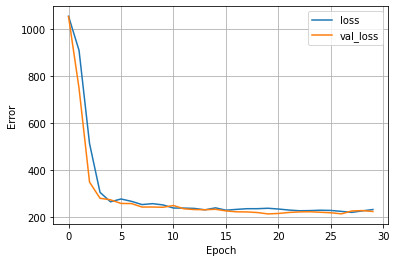

In [17]:
hf.plot_loss(history)

6/6 [==============================] - 0s 600us/step


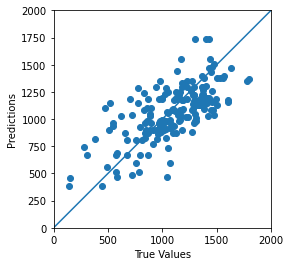

In [18]:
test_predictions = uts_model.predict(uts_test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(uts_test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0, 2000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)